In [1]:
print('hello world')

hello world


In [ ]:
print('test2') #

test2


In [3]:
import pandas as pd
import numpy as np
df1 = pd.read_csv(r'C:\Users\Patrick\Documents\Python\data\sp500_monthly (1).csv')
df1.head()

C:\Users\Patrick\AppData\Local\Temp\ipykernel_4464\1112742165.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r'C:\Users\Patrick\Documents\Python\data\sp500_monthly (1).csv')


,Unnamed: 0,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,prc,shrout,vol,cfacpr,cfacshr
0,1,2000-01-31,24010,ENTERGY CORP NEW,29364G10,11,1,4911,ETR,7366,1,1957-03-01,2024-12-31,-0.031553,24.9375,241283.0,190694.0,2.000000,2.0
1,3,2000-01-31,12749,K MART CORP,48258410,11,1,5331,KM,6307,1,1957-03-01,2002-01-16,-0.173913,8.3125,493698.0,874803.0,1.000000,1.0
2,5,2000-01-31,23819,HALLIBURTON CO,40621610,11,1,1389,HAL,5439,1,1957-03-01,2024-12-31,-0.102484,36.1250,441754.0,710393.0,2.000000,2.0
3,6,2000-01-31,25769,KERR MCGEE CORP,49238610,11,1,1311,KMG,6403,1,1984-10-04,2006-08-10,-0.108871,55.2500,86466.0,109249.0,2.176876,2.0
4,8,2000-01-31,13688,P G & E CORP,69331C10,11,1,4931,PCG,8264,1,1925-12-31,2019-01-17,0.070122,21.9375,383980.0,258969.0,1.000000,1.0


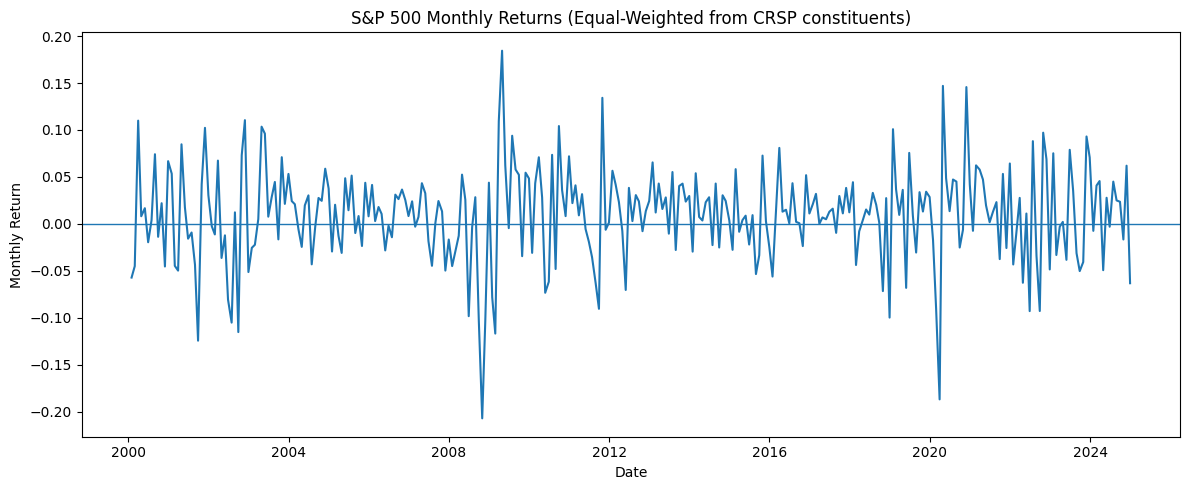

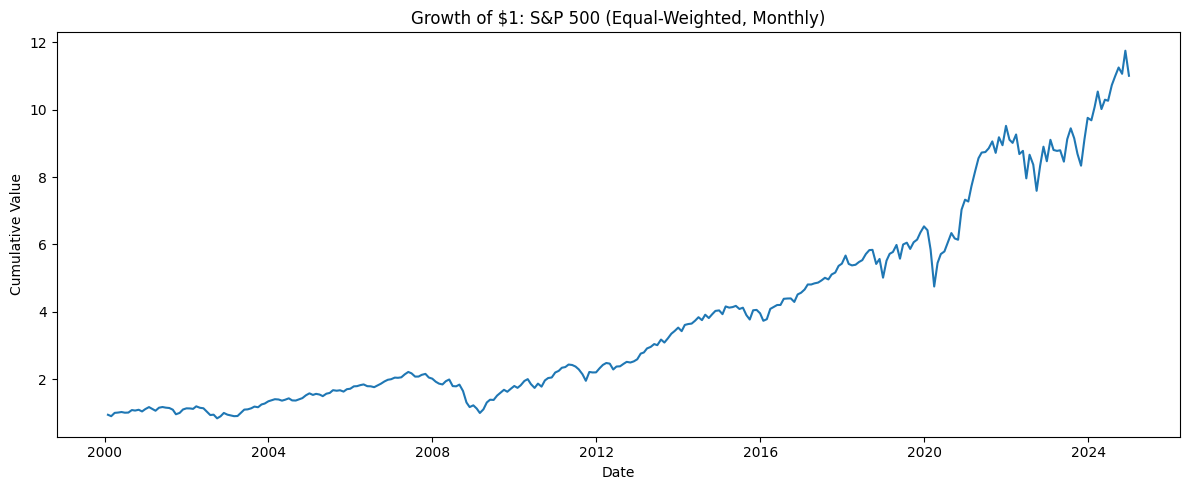

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
sp500ccm  = df1.drop("Unnamed: 0",axis=1)
sp500ccm.head()
# --- Make sure date is datetime and sorted ---
sp500ccm['date'] = pd.to_datetime(sp500ccm['date'])
sp500ccm = sp500ccm.sort_values(['date', 'permno'])

# --- (Optional but recommended) drop missing returns ---
df = sp500ccm.dropna(subset=['ret']).copy()

# --- Build an equal-weighted "S&P 500" monthly return series ---
# (mean across constituents each month)
sp500_ew_ret = df.groupby('date')['ret'].mean()

# --- Plot 1: Monthly returns ---
plt.figure(figsize=(12, 5))
plt.plot(sp500_ew_ret.index, sp500_ew_ret.values)
plt.axhline(0, linewidth=1)
plt.title("S&P 500 Monthly Returns (Equal-Weighted from CRSP constituents)")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.tight_layout()
plt.show()

# --- Plot 2: Cumulative growth of $1 ---
sp500_ew_cum = (1 + sp500_ew_ret).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(sp500_ew_cum.index, sp500_ew_cum.values)
plt.title("Growth of $1: S&P 500 (Equal-Weighted, Monthly)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.tight_layout()
plt.show()


In [6]:
sp500ccm.head()

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,prc,shrout,vol,cfacpr,cfacshr
152,2000-01-31,10078,SUN MICROSYSTEMS INC,86681010,11,3,3571,SUNW,12136,1,1992-08-20,2010-01-28,0.014528,78.56250,1561106.0,4163042.0,0.500000,0.5
351,2000-01-31,10104,ORACLE CORP,68389X10,11,3,7379,ORCL,12142,1,1989-08-03,2024-12-31,-0.108477,49.95313,2847344.0,5257006.0,2.000000,2.0
21,2000-01-31,10107,MICROSOFT CORP,59491810,11,3,7370,MSFT,12141,1,1994-06-07,2024-12-31,-0.161670,97.87500,5160025.0,6483703.0,2.000000,2.0
113,2000-01-31,10138,T ROWE PRICE ASSOC INC,74147710,11,3,6211,TROW,12138,1,1999-10-13,2024-12-31,0.052454,38.87500,120678.0,88960.0,2.000000,2.0
334,2000-01-31,10145,HONEYWELL INTERNATIONAL INC,43851610,11,1,3724,HON,1300,1,1925-12-31,2024-12-31,-0.167931,48.00000,789233.0,771383.0,1.047784,1.0


In [7]:
# Markowitz Mean-Variance Optimization for First Period
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Get the first period (first date in the dataset)
first_date = df['date'].min()
print(f"First period: {first_date}")

# Filter data for the first period
first_period_data = df[df['date'] == first_date].copy()

# Create a pivot table: rows = dates, columns = stocks (by ticker or permno)
# Use ticker as identifier, fallback to permno if ticker is missing
returns_pivot = first_period_data.pivot_table(
    values='ret', 
    index='date', 
    columns='ticker',
    aggfunc='first'
)

# If ticker has too many NaNs, use permno instead
if returns_pivot.isna().sum().sum() > len(returns_pivot) * 0.5:
    returns_pivot = first_period_data.pivot_table(
        values='ret', 
        index='date', 
        columns='permno',
        aggfunc='first'
    )
    asset_names = returns_pivot.columns.tolist()
else:
    asset_names = returns_pivot.columns.tolist()

# Drop any assets with NaN returns for this period
returns_pivot = returns_pivot.dropna(axis=1)

print(f"Number of assets in first period: {len(returns_pivot.columns)}")
print(f"Assets: {returns_pivot.columns.tolist()[:10]}...")  # Show first 10

# Get returns as a numpy array (single row for first period)
returns_array = returns_pivot.iloc[0].values

# Calculate mean returns (for this single period, it's just the returns themselves)
# For MV optimization, we need expected returns - use the returns as proxy
mu = returns_array

# Calculate covariance matrix
# Since we only have one period, we'll use a simple approach:
# For single period, covariance is not well-defined, so we'll use historical data
# Let's get a few periods of data to estimate covariance
n_periods = min(12, len(df['date'].unique()))  # Use up to 12 months
first_n_dates = sorted(df['date'].unique())[:n_periods]

# Build returns matrix for covariance estimation
returns_matrix = []
for date in first_n_dates:
    period_data = df[df['date'] == date]
    period_pivot = period_data.pivot_table(
        values='ret',
        index='date',
        columns='ticker' if 'ticker' in period_data.columns else 'permno',
        aggfunc='first'
    )
    # Align columns with first period
    period_pivot = period_pivot.reindex(columns=returns_pivot.columns)
    if not period_pivot.empty:
        returns_matrix.append(period_pivot.iloc[0].values)

returns_matrix = np.array(returns_matrix)

# Calculate covariance matrix
# Handle case where we might have NaN values
returns_matrix_clean = returns_matrix[:, ~np.isnan(returns_matrix).any(axis=0)]
mu_clean = mu[~np.isnan(returns_matrix).any(axis=0)]

if len(returns_matrix_clean) > 1:
    cov_matrix = np.cov(returns_matrix_clean.T)
else:
    # Fallback: use identity matrix scaled by variance if only one period
    cov_matrix = np.eye(len(mu_clean)) * np.var(mu_clean)

print(f"\nCovariance matrix shape: {cov_matrix.shape}")
print(f"Mean returns shape: {mu_clean.shape}")

# Markowitz Optimization
# Objective: minimize portfolio variance
# Constraints: 
#   1. Sum of weights = 1 (fully invested)
#   2. Weights >= 0 (no short selling)
#   3. Target return constraint (we'll optimize for different target returns)

def portfolio_variance(weights, cov_matrix):
    """Calculate portfolio variance"""
    return weights.T @ cov_matrix @ weights

def portfolio_return(weights, mu):
    """Calculate portfolio expected return"""
    return weights.T @ mu

# Constraints
n_assets = len(mu_clean)
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights = 1
]

# Bounds: no short selling (weights between 0 and 1)
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess: equal weights
initial_weights = np.ones(n_assets) / n_assets

# Optimize for minimum variance portfolio
result = minimize(
    portfolio_variance,
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

if result.success:
    min_var_weights = result.x
    min_var_return = portfolio_return(min_var_weights, mu_clean)
    min_var_variance = portfolio_variance(min_var_weights, cov_matrix)
    
    print("\n" + "="*60)
    print("MINIMUM VARIANCE PORTFOLIO (First Period)")
    print("="*60)
    print(f"Portfolio Return: {min_var_return:.4f} ({min_var_return*100:.2f}%)")
    print(f"Portfolio Variance: {min_var_variance:.6f}")
    print(f"Portfolio Std Dev: {np.sqrt(min_var_variance):.4f} ({np.sqrt(min_var_variance)*100:.2f}%)")
    print(f"\nNumber of assets: {n_assets}")
    print(f"\nTop 10 Holdings (by weight):")
    
    # Create DataFrame with weights
    weights_df = pd.DataFrame({
        'Asset': returns_pivot.columns[~np.isnan(returns_matrix).any(axis=0)],
        'Weight': min_var_weights,
        'Return': mu_clean
    }).sort_values('Weight', ascending=False)
    
    print(weights_df.head(10).to_string(index=False))
    print(f"\nTotal weight: {min_var_weights.sum():.6f}")
    
    # Also optimize for a target return (efficient frontier point)
    target_return = mu_clean.mean()  # Use average return as target
    
    constraints_with_return = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, mu_clean) - target_return}
    ]
    
    result_target = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_with_return
    )
    
    if result_target.success:
        target_weights = result_target.x
        target_var = portfolio_variance(target_weights, cov_matrix)
        
        print("\n" + "="*60)
        print(f"EFFICIENT PORTFOLIO (Target Return = {target_return:.4f})")
        print("="*60)
        print(f"Portfolio Return: {portfolio_return(target_weights, mu_clean):.4f}")
        print(f"Portfolio Variance: {target_var:.6f}")
        print(f"Portfolio Std Dev: {np.sqrt(target_var):.4f}")
        
        weights_df_target = pd.DataFrame({
            'Asset': returns_pivot.columns[~np.isnan(returns_matrix).any(axis=0)],
            'Weight': target_weights,
            'Return': mu_clean
        }).sort_values('Weight', ascending=False)
        
        print(f"\nTop 10 Holdings (by weight):")
        print(weights_df_target.head(10).to_string(index=False))
else:
    print("Optimization failed!")
    print(result.message)

First period: 2000-01-31 00:00:00
Number of assets in first period: 500
Assets: ['AA', 'AAPL', 'ABS', 'ABT', 'ABX', 'ACK', 'ACV', 'ADBE', 'ADCT', 'ADI']...

Covariance matrix shape: (437, 437)
Mean returns shape: (437,)

MINIMUM VARIANCE PORTFOLIO (First Period)
Portfolio Return: 0.0103 (1.03%)
Portfolio Variance: 0.000000
Portfolio Std Dev: 0.0004 (0.04%)

Number of assets: 437

Top 10 Holdings (by weight):
Asset   Weight    Return
 QTRN 0.025720  0.414716
  CCE 0.018295  0.254658
  BOL 0.016586 -0.094064
 CNXT 0.015393  0.273070
  GPS 0.015139 -0.028533
  EIX 0.015091  0.122482
 PAYX 0.014829  0.103813
  LLY 0.014190  0.005639
  CLX 0.013038 -0.048139
  GDT 0.012777  0.123670

Total weight: 1.000000

EFFICIENT PORTFOLIO (Target Return = -0.0570)
Portfolio Return: -0.0570
Portfolio Variance: 0.000013
Portfolio Std Dev: 0.0037

Top 10 Holdings (by weight):
Asset   Weight    Return
  BOL 0.049596 -0.094064
 YHOO 0.041903 -0.255670
  GPS 0.040652 -0.028533
  FON 0.039594 -0.039926
 ADPT 